In [ ]:
%reload_ext autoreload
%autoreload 2
# allow iterative matplotlib plots
%matplotlib widget
# %matplotlib inline

In [8]:
from IPython import display
import sys, os
sys.path.append(os.path.join(os.getcwd(),'..','..'))

import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from matplotlib import gridspec
from tqdm import tqdm
from pyro.distributions.multivariate_studentt import MultivariateStudentT

from CBOSS.bayesian_models.regression import GaussianProcessRegression, StudentTProcessRegression
from CBOSS.bayesian_models.svgp import *
from CBOSS.bayesian_models.kernels import PolynomialKernel, CombKernel, DiscreteDiffusionKernel, HammingKernel, RBFKernel


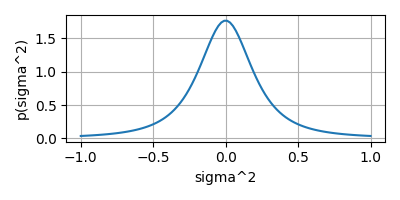

In [2]:
''' Define measurement noise
============================'''

from scipy import stats

# invgammap = lambda sigma0_2, L: stats.invgamma(a = L/2, loc = 0, scale = sigma0_2*L/2)

sigma2 = torch.distributions.studentT.StudentT(df=2, loc=0, scale=0.2)
sigma2_vals = torch.linspace(-1, 1, 100)

plt.figure(figsize=(4, 2))
plt.plot( sigma2_vals, torch.exp(sigma2.log_prob(sigma2_vals)), label = 'L = 1')
plt.xlabel('sigma^2')
plt.ylabel('p(sigma^2)')
plt.tight_layout()
plt.grid()
plt.show()

In [3]:

''' Init true function and measurements
============================'''

# define seed for torch
torch.manual_seed(12345)

# y_true_fun = lambda x: x**2 * np.sin(5 * np.pi * x)**6.0
y_true_fun = lambda x: -(1.4 - 3.0 * x) * np.sin(18.0 * x) # np.sin(1 * np.pi * x) * 2.0

l1,l2 = 0, 1.

# sigma2 = 0.2
N = 200
X = torch.rand(N, 1, dtype=torch.double) * (l2-l1) + l1
# noise = torch.randn(N) * sigma2
noise = torch.asarray( sigma2.rsample([N]) )
y = y_true_fun(X)[:,0] + noise
X_pred = torch.linspace(l1, l2, 1000, dtype=torch.double)[:,None]


In [4]:

''' Initialize Model
============================'''

ls = 0.2
sigma2m_prior = 0.2

reg_TP = StudentTProcessRegression(
    X = torch.as_tensor(X),
    y = torch.as_tensor(y),
    kernel = RBFKernel(length_scales=ls, variance_prior=1.0/sigma2m_prior),
    train_sigma2 = True,
    sigma2m_prior = sigma2m_prior
).double()
reg_TP.fit()
reg_TP.eval()

reg_GP = GaussianProcessRegression(
    X = torch.as_tensor(X),
    y = torch.as_tensor(y),
    kernel = RBFKernel(length_scales=ls, variance_prior=1.0),
    train_sigma2 = True,
    sigma2_prior = sigma2m_prior
).double()
reg_GP.fit()
reg_GP.eval()

Ns = N//2
s = torch.rand(N).argsort()[:Ns]
svgpr = SVGP(
    X=X, y=y, s=s,
    kernel = RBFKernel(length_scales=0.2, variance_prior=0.5),
    likelihood = GaussianLikelihood(sigma2_prior=sigma2m_prior, sigma2_hyperprior=1.),
    batch_size = N,
    optimizer = ['adam', 'lbfgs'][1]
).double()

svgpr.fit(lr=1.0, maxiter=300)
svgpr.eval()
# y_pred = svgpr.predict_y(X_pred)




========  TPReg. train report ============
	Time elapsed: 9.2 s
	nbr iterations: 16
	nbr fun evals:  19

	K.variance_prior               : [5.00] -> [5.05]
	K.length_scales                : [0.20] -> [0.09]
	sigma2m_prior_                 : [0.20] -> [0.10]
	L_prior_                       : [2.50] -> [2.94]
======== EOF TPReg. train report ==========


========  GPReg. train report ============
	Time elapsed: 106.2 s
	nbr iterations: 14
	nbr fun evals:  38

	K.variance_prior               : [1.00] -> [0.68]
	K.length_scales                : [0.20] -> [0.09]
	sigma2                         : [0.20] -> [0.13]
======== EOF GPReg. train report ==========


========  SVGP train report ============
	Time elapsed:   1.4 s
	nbr evals:      101
	elbo:           -1.1e+02
	
	likelihood.sigma2              : [0.20] -> [0.14]
	K.variance_prior               : [0.50] -> [0.42]
	K.length_scales                : [0.20] -> [0.09]
======== EOF SVGP train report ==========



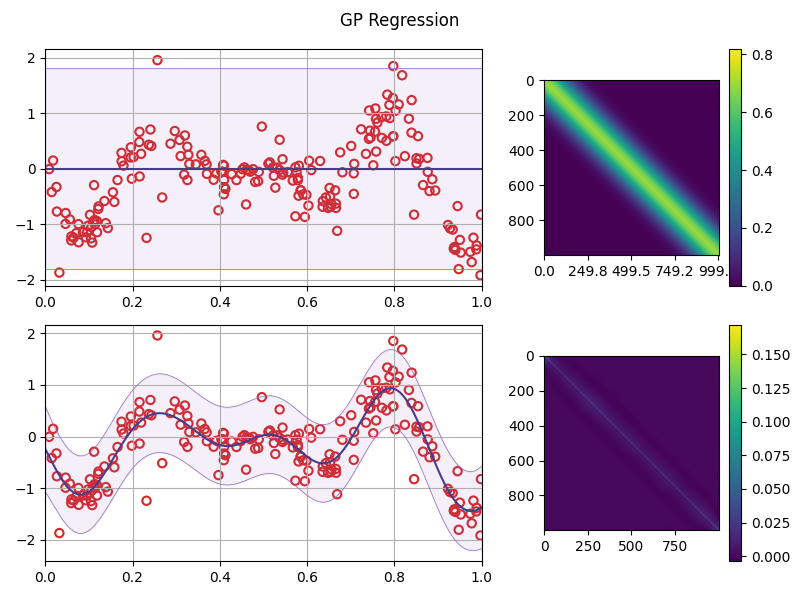

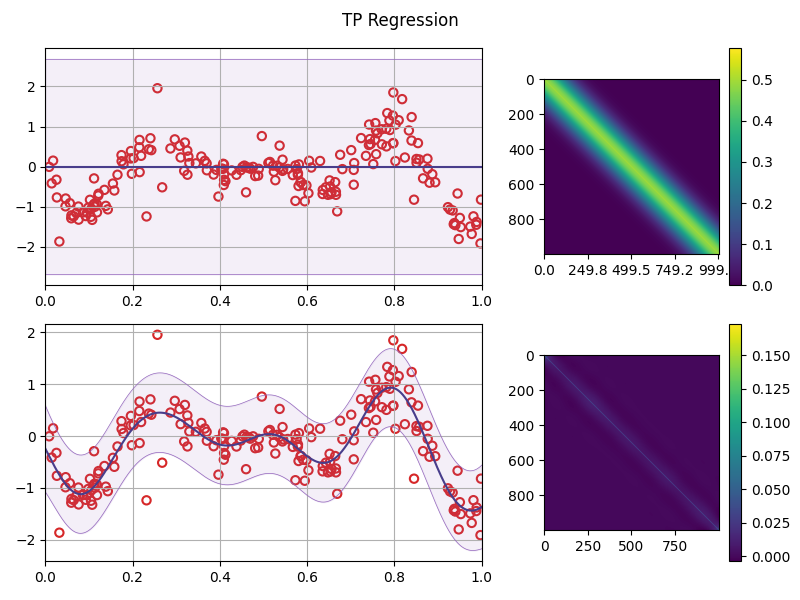

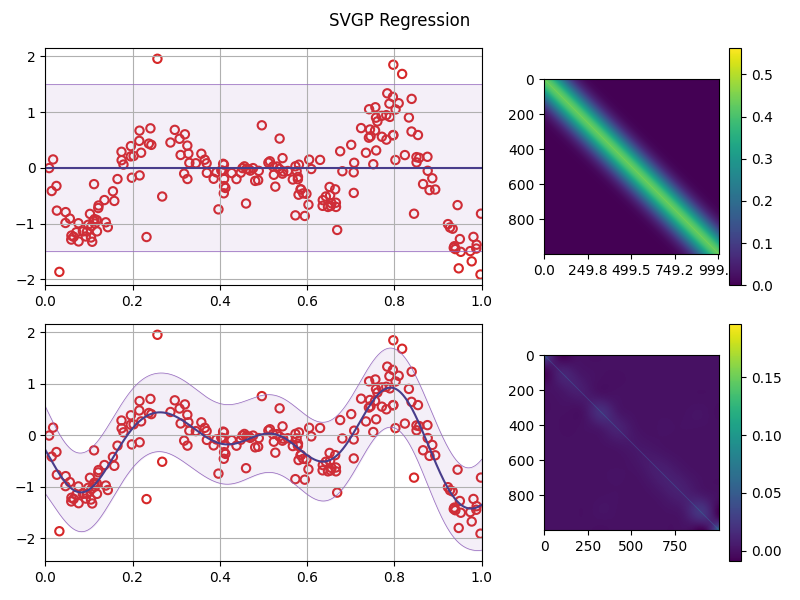

No such comm: b4a74cd9c1f1491fbb3a3b38486901c3


In [5]:
plt.close()

regs ={
    'GP': reg_GP,
    'TP': reg_TP,
    'SVGP': svgpr
}

for reg_name, reg in regs.items():

    with torch.no_grad():
        # calculate predictive prior
        y_pred_prior      = reg.predictive_prior(X_pred=X_pred, include_noise=True)
        y_pred_prior_mean = y_pred_prior.loc
        y_pred_prior_std  = y_pred_prior.variance ** 0.5
                
        # calculate predictive posterior
        y_pred_post      = reg.predictive_posterior(X_pred=X_pred, include_noise=True)
        y_pred_post_mean = y_pred_post.loc
        y_pred_post_std  = y_pred_post.variance ** 0.5

        gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[1, 1])

        fig = plt.figure(figsize=(8,6))
        ''' --- predictive prior plot -- '''
        ax_prior = plt.subplot(gs[0,0])
        ax_prior.scatter(X, y, c='tab:red', s=6**2, marker=MarkerStyle('o', 'none'), label='Measurements')
        ax_prior.plot(X_pred, y_pred_prior_mean, color='darkslateblue', label='Predictive Prior')
        ax_prior.fill_between(x=X_pred.squeeze(), y1=y_pred_prior_mean+2*y_pred_prior_std, y2=y_pred_prior_mean-2*y_pred_prior_std, alpha=0.1, color='tab:purple')
        ax_prior.plot(X_pred, y_pred_prior_mean+2*y_pred_prior_std, color='tab:purple', linewidth=0.5)
        ax_prior.plot(X_pred, y_pred_prior_mean-2*y_pred_prior_std, color='tab:purple', linewidth=0.5)
        # ax_prior.legend(loc='upper right')
        ax_prior.grid()
        ax_prior.set_xlim([X_pred.min(), X_pred.max()])

        ''' --- prior covariance plot -- '''
        ax_priorcov = plt.subplot(gs[0,1])
        p = ax_priorcov.imshow(y_pred_prior.covariance_matrix, cmap='viridis')
        # set ticks of p to X_pred
        ax_priorcov.set_xticks(np.linspace(0, len(X_pred)-1, 5))
        fig.colorbar(p, ax=ax_priorcov)

        ''' --- predictive posterior plot -- '''
        ax_post = plt.subplot(gs[1,0])
        ax_post.scatter(X, y, c='tab:red', s=6**2, marker=MarkerStyle('o', 'none'), label='Measurements')
        ax_post.plot(X_pred, y_pred_post_mean, color='darkslateblue', label='Predictive Posterior')
        # add a thin line on the boundaries of the fill_between
        ax_post.fill_between(x=X_pred.squeeze(), y1=y_pred_post_mean+2*y_pred_post_std, y2=y_pred_post_mean-2*y_pred_post_std, alpha=0.1, color='tab:purple')
        ax_post.plot(X_pred, y_pred_post_mean+2*y_pred_post_std, color='tab:purple', linewidth=0.5)
        ax_post.plot(X_pred, y_pred_post_mean-2*y_pred_post_std, color='tab:purple', linewidth=0.5)
        ax_post.grid()
        ax_post.set_xlim([X_pred.min(), X_pred.max()])
        
        ''' --- posterior covariance plot -- '''
        ax_postcov = plt.subplot(gs[1,1])
        # plot the posterior covariance as an image
        p = ax_postcov.imshow(y_pred_post.covariance_matrix, cmap='viridis')
        # add colorscale
        fig.colorbar(p, ax=ax_postcov)
        
        plt.suptitle(f'{reg_name} Regression')
        plt.tight_layout()



## Create Animation

In [6]:
# skip this cell
%%script false --no-raise-error

for i in tqdm(range(100)):
    
    Xi = X[:i+1]
    yi = y[:i+1]
    
    reg = StudentTProcessRegression(
        X = torch.as_tensor(Xi),
        y = torch.as_tensor(yi),
        kernel = RBFKernel(length_scales=0.1, variance_prior=1.0/sigma2),
        train_sigma2 = True,
        sigma2m_prior = sigma2
    ).double()
    # reg.fit(disp=False)
    reg.eval()
    
    with torch.no_grad():
        
        # calculate predictive prior
        y_pred_prior      = reg.predictive_prior(X_pred=X_pred, include_noise=True)
        y_pred_prior_mean = y_pred_prior.loc
        y_pred_prior_std  = y_pred_prior.variance ** 0.5
                
        # calculate predictive posterior
        y_pred_post      = reg.predictive_posterior(X_pred=X_pred, include_noise=True)
        y_pred_post_mean = y_pred_post.loc
        y_pred_post_std  = y_pred_post.variance ** 0.5
        
        
        gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[1, 1])

        fig = plt.figure(figsize=(8,6))
        ''' --- predictive prior plot -- '''
        ax_prior = plt.subplot(gs[0,0])
        ax_prior.scatter(Xi, yi, c='tab:red', s=6**2, marker=MarkerStyle('o', 'none'), label='Measurements')
        ax_prior.plot(X_pred, y_pred_prior_mean, color='darkslateblue', label='Predictive Prior')
        ax_prior.fill_between(x=X_pred.squeeze(), y1=y_pred_prior_mean+2*y_pred_prior_std, y2=y_pred_prior_mean-2*y_pred_prior_std, alpha=0.1, color='tab:purple')
        ax_prior.plot(X_pred, y_pred_prior_mean+2*y_pred_prior_std, color='tab:purple', linewidth=0.5)
        ax_prior.plot(X_pred, y_pred_prior_mean-2*y_pred_prior_std, color='tab:purple', linewidth=0.5)
        # ax_prior.legend(loc='upper right')
        ax_prior.grid()
        ax_prior.set_xlim([X_pred.min(), X_pred.max()])
        ax_prior.set_ylim([-2,1.5])

        ''' --- prior covariance plot -- '''
        ax_priorcov = plt.subplot(gs[0,1])
        p = ax_priorcov.imshow(y_pred_prior.covariance_matrix, cmap='viridis')
        # set ticks of p to X_pred
        ax_priorcov.set_xticks(np.linspace(0, len(X_pred)-1, 5))
        fig.colorbar(p, ax=ax_priorcov)

        ''' --- predictive posterior plot -- '''
        ax_post = plt.subplot(gs[1,0])
        ax_post.scatter(Xi, yi, c='tab:red', s=6**2, marker=MarkerStyle('o', 'none'), label='Measurements')
        ax_post.plot(X_pred, y_pred_post_mean, color='darkslateblue', label='Predictive Posterior')
        # add a thin line on the boundaries of the fill_between
        ax_post.fill_between(x=X_pred.squeeze(), y1=y_pred_post_mean+2*y_pred_post_std, y2=y_pred_post_mean-2*y_pred_post_std, alpha=0.1, color='tab:purple')
        ax_post.plot(X_pred, y_pred_post_mean+2*y_pred_post_std, color='tab:purple', linewidth=0.5)
        ax_post.plot(X_pred, y_pred_post_mean-2*y_pred_post_std, color='tab:purple', linewidth=0.5)
        ax_post.grid()
        ax_post.set_xlim([X_pred.min(), X_pred.max()])
        ax_post.set_ylim([-2,1.5])
        
        ''' --- posterior covariance plot -- '''
        ax_postcov = plt.subplot(gs[1,1])
        # plot the posterior covariance as an image
        p = ax_postcov.imshow(y_pred_post.covariance_matrix, cmap='viridis')
        # add colorscale
        fig.colorbar(p, ax=ax_postcov, format='%3.2f')
        
        plt.suptitle(f'{reg_name} Regression')
        plt.tight_layout()
        
        plt.savefig(f'./regression_animation/regression_TP_{i:03d}.png')
        plt.close()

UsageError: Line magic function `%%script` not found.


In [7]:
%%script false --no-raise-error

# create a gif from the images
import imageio.v3 as imageio
import glob

total_time = 10.

images = []
filenames = glob.glob('./regression_animation/*.png')
filenames.sort()
for filename in tqdm(filenames):
    images.append(imageio.imread(filename))
imageio.imwrite('./regression_animation/regression_TP.gif', images, duration=total_time/len(filenames), loop=0)
